In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_W4G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri Mar 19 13:36:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 28%   56C    P0    72W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 52%   

In [3]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [4]:
save_dir = '/data/save/model_W4G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [5]:
!ls $save_dir

data.json    save_101436  save_102141  save_400000
save_100000  save_101938  save_102658


In [6]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams, mode='inference')
model = model.cuda()
step = 400000

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, _, _ = logger.load(step, model, None)
print(step)

print('done')

Model size 13.5MiB
TTS size 13.5MiB
MelDecoder size 11.6MiB
loaded : 400000
400000
done


In [7]:
testset = LJDataset(tts_hparams, split='test')
collate_fn = TextMelCollate(tts_hparams)

test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [8]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

In [9]:
!mkdir inference

mkdir: `inference' 디렉토리를 만들 수 없습니다: 파일이 있습니다


In [10]:
sentences = [
'The Middle Ages brought calligraphy to perfection, and it was natural therefore.',
'that the forms of printed letters should follow more or less closely those of the written character, and they followed them very closely.',
'especially as regards the lower case letters; and type very similar was used during the next fifteen or twenty years not only by Schoeffer,.',
'In fourteen sixty five Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,.',
'and used an exceedingly beautiful type, which is indeed to look at a transition between Gothic and Roman,.',
'John of Spires and his brother Vindelin, followed by Nicholas Jenson, began to print in that city,.',
'fourteen sixty nine, fourteen seventy;.',
'and though the famous family of Aldus restored its technical excellence, rejecting battered letters,.',
'yet their type is artistically on a much lower level than Jenson\'s, and in fact.',
'they must be considered to have ended the age of fine printing in Italy.',
'Jenson, however, had many contemporaries who used beautiful type,.',
'It must be understood that through the whole of the fifteenth and the first quarter of the sixteenth centuries.',
'Most of Caxton\'s own types are of an earlier character, though they also much resemble Flemish or Cologne letter.',
'the best, mostly French or Low Country, was neat and clear, but without any distinction;.',
'and things got worse and worse through the whole of the seventeenth century, so that in the eighteenth printing was very miserably performed.',
'were the leaders in this luckless change, though our own Baskerville, who was at work some years before them, went much on the same lines;.',
'These and similar founts, cast by the above firm and others,.',
'but the general revival of the old forms has made no way in those countries.',
'which title can only be claimed by artistic practice, whether the art in it be conscious or unconscious.',
'and the elegance and legibility of the ancient more striking than in the Arabic numerals.',
'that he has a five, an eight, or a three before him, unless the press work is of the best:.',
'this is awkward if you have to read Bradshaw\'s Guide in a hurry.',
'this is the narrowing of the modern letters.',
'the modern letters are narrowed by a third or thereabout; but while this gain of space very much hampers the possibility of beauty of design,.',
'In good printing the spaces between the words should be as near as possible equal.',
'it is impossible that they should be quite equal except in lines of poetry.',
'modern printers generally overdo the "whites" in the spacing, a defect probably forced on them by the characterless quality of the letters.',
'which requires the constant exercise of judgment and taste on the part of the printer.',
'The position of the page on the paper should be considered if the book is to have a satisfactory look.',
'The modern printer, in the teeth of the evidence given by his own eyes, considers the single page as the unit, and prints the page in the middle of his paper.',
'and that laterally the page looks as if it were being driven off the paper.',
'The paper on which the printing is to be done is a necessary part of our subject:.',
'is the habit that publishers have of eking out a thin volume by printing it on thick paper almost of the substance of cardboard,.',
'because the modern practice is to disregard the relation between the printing and the ornament altogether,.',
'so that if the two are helpful to one another it is a mere matter of accident.',
'The due relation of letter to pictures and other ornament was thoroughly understood by the old printers; so that.',
'all books might be at least comely and well looking: and if to these good qualities were added really beautiful ornament and pictures,.',
'Under the conditions referred to in the previous chapter,.',
'The new jail fell as far short of the demands made on it as did the old.',
'Neild gives some figures which well illustrate this.',
'On the fourteenth June, eighteen hundred, there were one hundred ninety nine debtors and two hundred eighty nine felons in the prison.',
'After that they fell as steadily,.',
'who seldom let a session go by without visiting Newgate.',
'In eighteen thirteen.',
'In order to realize the evils entailed by incarceration in Newgate in these days, it is necessary to give some account of its interior.',
'A high wall fifteen feet in height divided the females\' court yard from the men\'s.',
'But these king\'s witnesses were also put at times into the press yard among the capital convicts, seemingly a very dangerous proceeding,.',
'to the various wards their friends occupied.',
'It was large and comparatively commodious, being maintained on a better footing than any other part of the prison.',
'The state side contained twelve good sized rooms,.',
'eight. The female felons were deprived of part of the space which the architect had intended for them.',
'can be permitted to enter the interior of this prison. End quote. The tap room and bar were just behind the felons\' entrance lodge,.',
'watch all night. Adjoining the felons\' side lodge is the keeper\'s office, where the prison books are kept, and his clerk,.',
'The frequency and extent of processes against debtors seventy or eighty years ago will appear almost incredible.',
'in an age when insolvent acts and bankruptcy courts do so much to relieve the impecunious,.',
'and imprisonment for debt has almost entirely disappeared.',
'a table showing the figures for the year ending Michaelmas eighteen oh two.',
'In that period upwards of two hundred thousand writs.',
'had been issued for the arrests of debtors in the kingdom, for sums varying from fourpence to five hundred pounds and upwards.',
'Quite half of the foregoing writs and arrests applied to sums under thirty pounds.',
'Neild also says that in seventeen ninety three,.',
'five thousand, seven hundred nineteen writs and executions for debts between ten pounds and twenty pounds were issued in Middlesex,.',
'He also makes the curious calculation that the costs of these actions if undefended.',
'two hundred eighty five thousand, nine hundred fifty pounds; in other words, that to recover eighty odd thousand pounds,.',
'An elaborate machinery planned for the protection of the trader, and altogether on his side, had long existed for the recovery of debts.',
'So much inconvenience ensued, that in fifteen eighteen the Corporation obtained from Parliament an act empowering two aldermen.',
'under forty shillings arising within the city.',
'The activity as well as the futility of these courts may be estimated from the statement given by Neild.',
'that thirteen hundred and twelve debtors were committed by them to Newgate between seventeen ninety seven and eighteen oh eight,.',
'The latter indeed hung like millstones round the neck of the unhappy insolvent wretches who found themselves in limbo.',
'Thus, amongst others, Thomas Blackburn had been committed on October fifteenth for a debt of one shilling five pence.',
'Other cases are recorded elsewhere, as at the Giltspur Street Compter, where in eighteen oh five Mr. Neild found a man named William Grant.',
'He recites another most outrageous and extraordinary case, in which one John Bird,.',
'Bird was, however, discharged within three days by a subscription raised among his fellow prisoners.',
'Mr. Buxton, in his "Inquiry into the System of Prison Discipline,".',
'The lad in question was found in Coldbath Fields prison, to which he had been sent for a month in default of paying a fine of forty shillings.',
'Before dealing with the debtors in Newgate, I may refer incidentally.',
'Every new comer was entitled to a "chummage" ticket, but did not always get it,.',
'No fixed rates or rules governed the hiring out of rooms or parts of a room, and all sorts of imposition was practiced.',
'The best, or at least the most influential prisoners, got lodging in the State House, which contained "eight large handsome rooms.".',
'The office of marshal had been hereditary,.',
'A man dying of liver complaint lay on the cold stones without a bed or food to eat.',
'The yards were taken up with rackets and five courts, and here and there were "bumble puppy grounds," a game in which the players rolled iron balls.',
'In consequence of these disclosures, both Bambridge and Huggin, his predecessor in the office, were committed to Newgate,.',
'Disturbances were frequent, owing to the riotous conduct of intoxicated women.',
'Twice a week there was a wine and beer club held at night, which lasted till two or three in the morning.',
'Matters were rather better at the Marshalsea.',
'At one time the Marshalsea was the receptacle of pirates, but none were committed to it after seventeen eighty nine.',
'but its business was much reduced by the extension of the Courts of Conscience.',
'The population, as reported by the committee in eighteen fourteen, averaged about sixty,.',
'A court of the collegians was held every Monday to manage its affairs, at which all prisoners were required to attend.',
'but the prevailing moral tone may be guessed from the penalty inflicted upon persons singing obscene songs before nine p.m.',
'The poorer prisoners were not in abject want, as in other prisons,.',
'went outside and beyond the prison to call on their creditors, and try to arrange their debts, but this practice was discontinued.',
'Neild found the prisoners in the Borough Compter ragged, starving, and dirty.',
'Garnish on the cabin side was a guinea at entrance for coals, candles, brooms, etc., and a gallon of beer on discharge;.',
'on the master\'s side it was thirteen and fourpence, and a gallon of beer on entrance, although Mr. Newman,.',
'Besides these fees, legitimate and illegitimate, there were others which must be paid before release.',
'and thus when the debtor\'s debt had been actually paid, or when he had abandoned his property to the creditors, and, almost destitute,.',
'a severe winter set in, the new stock had not been supplied by the contractors, and the poor debtors perished of cold.',
]

0.026740550994873047


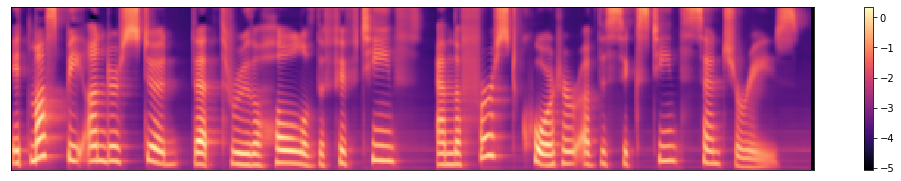

(139776,)


In [32]:
t0 = time.time()
text = "It must be understood that through the whole of the fifteenth and the first quarter of the sixteenth centuries."
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

In [11]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 
import soundfile as sf
from g2p_en import G2p

g2p = G2p()

temperature = 1.0
inference_dir = 'inference/W4G/'
!mkdir $inference_dir

model.eval()
vocoder.eval()
with torch.no_grad():
    for i, sentence in enumerate(sentences):
        print(i, sentence)
        text = sentence
        text_array = g2p(text)
        text = ""
        for t in text_array:
            text += t

        text_utf = text.encode()
        ts = [0]
        for t in text_utf:
            ts.append(t)
        ts.append(0)    
        utf8_values = np.array(ts)
        t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
        model.eval()
        with torch.no_grad():

            samples, time_dict = model.inference(t, None, None, temperature=1.0)
            _s = samples.data.cpu().numpy()

        _mel = _s[0].T
        _mel = (_mel - mean) / scale
        mel = torch.from_numpy(_mel).cuda()
        wav = vocoder.inference(mel)
        _wav = wav[:, 0].data.cpu().numpy()
        save_path = inference_dir + 'inference_' + str(i) + '_W4G.wav'
        sf.write(save_path, _wav, 22050, subtype='PCM_16')
        
print('done')

mkdir: `inference/W4G/' 디렉토리를 만들 수 없습니다: 파일이 있습니다
0 The Middle Ages brought calligraphy to perfection, and it was natural therefore.
1 that the forms of printed letters should follow more or less closely those of the written character, and they followed them very closely.
2 especially as regards the lower case letters; and type very similar was used during the next fifteen or twenty years not only by Schoeffer,.
3 In fourteen sixty five Sweynheim and Pannartz began printing in the monastery of Subiaco near Rome,.
4 and used an exceedingly beautiful type, which is indeed to look at a transition between Gothic and Roman,.
5 John of Spires and his brother Vindelin, followed by Nicholas Jenson, began to print in that city,.
6 fourteen sixty nine, fourteen seventy;.
7 and though the famous family of Aldus restored its technical excellence, rejecting battered letters,.
8 yet their type is artistically on a much lower level than Jenson's, and in fact.
9 they must be considered to have ended t

83 In consequence of these disclosures, both Bambridge and Huggin, his predecessor in the office, were committed to Newgate,.
84 Disturbances were frequent, owing to the riotous conduct of intoxicated women.
85 Twice a week there was a wine and beer club held at night, which lasted till two or three in the morning.
86 Matters were rather better at the Marshalsea.
87 At one time the Marshalsea was the receptacle of pirates, but none were committed to it after seventeen eighty nine.
88 but its business was much reduced by the extension of the Courts of Conscience.
89 The population, as reported by the committee in eighteen fourteen, averaged about sixty,.
90 A court of the collegians was held every Monday to manage its affairs, at which all prisoners were required to attend.
91 but the prevailing moral tone may be guessed from the penalty inflicted upon persons singing obscene songs before nine p.m.
92 The poorer prisoners were not in abject want, as in other prisons,.
93 went outside an

In [39]:
utf8_values

array([ 0, 65, 72, 48, 32, 83, 65, 72, 48, 86, 73, 72, 49, 82, 32, 87, 73,
       72, 49, 78, 84, 69, 82, 48, 32, 83, 69, 72, 49, 84, 32, 73, 72, 48,
       78, 32, 44, 32, 68, 72, 65, 72, 48, 32, 78, 85, 87, 49, 32, 83, 84,
       65, 65, 49, 75, 32, 72, 72, 65, 69, 49, 68, 32, 78, 65, 65, 49, 84,
       32, 66, 73, 72, 49, 78, 32, 83, 65, 72, 48, 80, 76, 65, 89, 49, 68,
       32, 66, 65, 89, 49, 32, 68, 72, 65, 72, 48, 32, 75, 65, 65, 49, 78,
       84, 82, 65, 69, 50, 75, 84, 69, 82, 48, 90, 32, 44, 32, 65, 72, 48,
       78, 68, 32, 68, 72, 65, 72, 48, 32, 80, 85, 72, 49, 82, 32, 68, 69,
       72, 49, 84, 69, 82, 48, 90, 32, 80, 69, 72, 49, 82, 73, 72, 48, 83,
       72, 84, 32, 65, 72, 49, 86, 32, 75, 79, 87, 49, 76, 68, 32, 46,  0])